In [20]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import os
import glob
import numpy as np
import time
from IPython import display
import tensorflow_probability as tfp

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
from tensorflow.keras.models import *
from keras import optimizers
from keras import metrics
from tensorflow import keras

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dir = '/content/drive/MyDrive/dataset/'

In [6]:
classes=['freshapples',
        #  'freshbanana',
        #  'freshoranges',
         ]

In [7]:
# os.listdir(dir + 'train/' + classes[0])

In [8]:
shape = (256, 256)

In [9]:
train_data = []

for i in range(len(classes)):
  path = dir + '/train/' + classes[i] + '/*.png'
  for filename in glob.glob(path):
    img = cv2.imread(filename)
    img = cv2.resize(img, shape)
    train_data.append(img)
train_data = np.array(train_data)
print(train_data.shape)

(1693, 256, 256, 3)


In [10]:
from sklearn.model_selection import train_test_split

In [11]:
x_train, x_val = train_test_split(train_data, test_size = 0.33, random_state = 42, shuffle = True)
print(x_train.shape)
print(x_val.shape)

(1134, 256, 256, 3)
(559, 256, 256, 3)


In [24]:
x_train = x_train/255
x_val = x_val/255

In [25]:
train_size = len(x_train)
batch_size = 32
test_size = len(x_val)

In [26]:
train_dataset = (tf.data.Dataset.from_tensor_slices(x_train)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_val)
                .shuffle(test_size).batch(batch_size))

In [34]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            InputLayer(input_shape=(256, 256, 3)),
            Conv2D(filters=16, kernel_size=3, activation='relu', padding = 'same'),
            Conv2D(filters=16, kernel_size=3, activation='relu', padding = 'same'),
            BatchNormalization(),
            MaxPooling2D(),
            Conv2D(filters=32, kernel_size=3, activation='relu', padding = 'same'),
            Conv2D(filters=32, kernel_size=3, activation='relu', padding = 'same'),
            BatchNormalization(),
            MaxPooling2D(),
            Conv2D(filters=64, kernel_size=3, padding = 'same', activation='relu'),
            Conv2D(filters=64, kernel_size=3, padding = 'same', activation='relu'),
            Conv2D(filters=64, kernel_size=3, padding = 'same', activation='relu'),
            BatchNormalization(),
            MaxPooling2D(),
            Conv2D(64, 3, activation = 'relu', padding = 'same'),
            Conv2D(64, 3, activation = 'relu', padding = 'same'),
            Conv2D(64, 3, activation = 'relu', padding = 'same'),
            BatchNormalization(),
            MaxPooling2D(),
            Conv2D(128, 3, activation = 'relu', padding = 'same'),
            Conv2D(128, 3, activation = 'relu', padding = 'same'),
            Conv2D(256, 3, activation = 'relu', padding = 'same'),
            BatchNormalization(),
            MaxPooling2D(), # 8 x 8
            Conv2D(256, 3, activation = 'relu', padding = 'same', strides = 2),
            Flatten(),
            # No activation
            Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            InputLayer(input_shape=(latent_dim,)),
            Dense(units=4*4*256, activation=tf.nn.relu),
            Reshape(target_shape=(4, 4, 256)),
            Conv2DTranspose(filters=256, kernel_size=3, padding = 'same', strides = 2, activation='relu'),
            UpSampling2D(),
            Conv2DTranspose(filters=256, kernel_size=3, padding = 'same', activation='relu'),
            Conv2DTranspose(filters=128, kernel_size=3, padding = 'same', activation='relu'),
            Conv2DTranspose(filters=128, kernel_size=3, padding = 'same', activation='relu'),
            UpSampling2D(),
            Conv2DTranspose(filters=64, kernel_size=3, padding = 'same', activation='relu'),
            Conv2DTranspose(filters=64, kernel_size=3, padding = 'same', activation='relu'),
            Conv2DTranspose(filters=64, kernel_size=3, padding = 'same', activation='relu'),
            UpSampling2D(),
            Conv2DTranspose(filters=32, kernel_size=3, padding = 'same', activation='relu'),
            Conv2DTranspose(filters=32, kernel_size=3, padding = 'same', activation='relu'),
            Conv2DTranspose(filters=32, kernel_size=3, padding = 'same', activation='relu'),
            UpSampling2D(),
            Conv2DTranspose(filters=16, kernel_size=3, padding = 'same', activation='relu'),
            Conv2DTranspose(filters=16, kernel_size=3, padding = 'same', activation='relu'),
            UpSampling2D(),
            Conv2DTranspose(filters=8, kernel_size=3, padding = 'same', activation='relu'),
            Conv2DTranspose(filters=8, kernel_size=3, padding = 'same', activation='relu'),
            # No activation
            Conv2DTranspose(filters=3, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [37]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.keras.losses.binary_crossentropy(x, x_logit)
  logpx_z = -tf.reduce_sum(cross_ent)
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [38]:
epochs = 140
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 32
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [32]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap = 'gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [30]:
# Pick a sample of the test set for generating output images
batch_size = 32
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 140, Test set ELBO: -778363.1875, time elapse for current epoch: 6.79413366317749


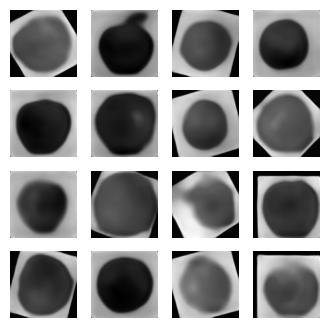

In [39]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

In [40]:
import PIL
import imageio

In [41]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 399.5, 399.5, -0.5)

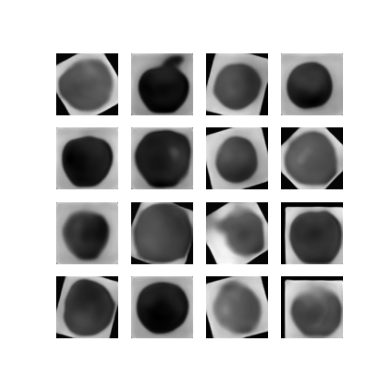

In [42]:
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images

In [43]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-43-a6dbd3b71488>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-43-a6dbd3b71488>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [45]:
import tensorflow_docs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.6/183.6 kB 4.3 MB/s eta 0:00:00


In [46]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# def scheduler(epoch, lr):
#   if epoch < 70:
#     return lr
#   else:
#     return lr * tf.math.exp(-0.1)

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
# checkpoint_path =  '/content/drive/MyDrive/DL_project/vae/cp.ckpt'
# checkpoint_dir = os.path.dirname(checkpoint_path)
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=False,
#                                                  verbose=1)

In [ ]:
# # compile and train the model
# vae = VAE(encoder, decoder)
# vae.compile(optimizer ='rmsprop')
# history = vae.fit(x_train, epochs = 100, batch_size = 64, callbacks=[lr_schedule, cp_callback])

In [ ]:
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(loss) + 1)
# plt.plot(epochs, loss, label='Training loss')
# plt.plot(epochs, val_loss, label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [ ]:
# import pandas as pd

# hist_df = pd.DataFrame(history.history)
# hist_csv_file = 'history.csv'
# with open(hist_csv_file, mode='w') as f:
#     hist_df.to_csv(f)